In [ ]:
import numpy as np
import pandas as pd
import tqdm
from scipy.stats import chi2
import matplotlib.pyplot as plt

def actual_monte_carlo_variance(statistic, distribution, n):
    bootstrap_data = []
    for i in range(20000):

        if distribution == "normal":
            data = np.random.normal(loc = 0, scale = 1, size = n)
        elif distribution == "chisquare":
            data = np.random.chisquare(df=1, size = n)
        else:
            raise ValueError("Invalid distribution")
        if statistic == "mean":
            T_n = np.mean(data)
        elif statistic == "median":
            T_n = np.median(data)
        bootstrap_data.append(T_n)
    return np.var(bootstrap_data)

def actual_asymp_variance(statistic, distribution, n):
    if statistic == "mean":
        if distribution == "normal":
            return 1 / n
        elif distribution == "chisquare":
            return 2 / n
        else:
            raise ValueError("Invalid distribution for mean statistic")
        
    elif statistic == "median":
        if distribution == "normal":
            return (np.pi) / (2 * n )
        elif distribution == "chisquare":
            m = chi2.ppf(0.5, df=1)          # population median
            f_m = chi2.pdf(m, df=1)          # pdf at median
            return 1 / (4 * n * f_m**2)
        else:
            raise ValueError("Invalid distribution for median statistic")
    else:
        raise ValueError("Invalid statistic")

def jackknife_variance(data, statistic="median"):
    n = len(data)
    if statistic == "mean":
        T_n_j = [np.mean(np.delete(data, i)) for i in range(n)]
    elif statistic == "median":
        T_n_j = [np.median(np.delete(data, i)) for i in range(n)]
    v_jack = (n - 1) / n * np.sum([(T_n_j[i] - np.mean(T_n_j))**2 for i in range(n)])
    return v_jack

def bootstrap_variance(data, statistic="median", B=1000):
    n = len(data)
    T_n_b = []
    for _ in range(B):
        sample = np.random.choice(data, size=n, replace=True)
        if statistic == "mean":
            T_n_b.append(np.mean(sample))
        elif statistic == "median":
            T_n_b.append(np.median(sample))
    v_boot = np.var(T_n_b)
    return v_boot

def get_performance(statistic, distribution):
    performance_dict = {}
    for n in [10,30,70,100]:
        jack_performances = []
        boot_performances = []
        V_T_n_boot = actual_monte_carlo_variance(statistic, distribution,n)
        V_T_n_asymp = actual_asymp_variance(statistic, distribution, n)

        for _ in tqdm.tqdm(range(5000)):
            if distribution == "normal":
                data = np.random.normal(loc = 0,scale = 1,size = n)
            elif distribution == "chisquare":
                data = np.random.chisquare(df=1, size = n)
            v_jack = jackknife_variance(data, statistic=statistic)
            jack_performances.append(v_jack / V_T_n_boot)
            v_boot = bootstrap_variance(data, statistic=statistic, B=100)
            boot_performances.append(v_boot / V_T_n_boot)

        performance_dict[n] = {
            "jack_performance_avg": np.mean(jack_performances),
            "jack_performance_sd": np.std(jack_performances),
            "boot_performance_avg": np.mean(boot_performances),
            "boot_performance_sd": np.std(boot_performances),
            "asymp_performance": V_T_n_asymp / V_T_n_boot
        }
    return pd.DataFrame(performance_dict).T

In [2]:
def plot_performance(results, statistic, distribution):
    """
    Plot performance comparison of jackknife, bootstrap, and asymptotic methods.
    
    Parameters:
    -----------
    results : pd.DataFrame
        DataFrame containing performance metrics
    statistic : str
        Type of statistic ('mean' or 'median')
    distribution : str
        Type of distribution ('normal' or 'chisquare')
    """
    n_values = results.index.values
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot reference line at y=1
    ax.axhline(y=1, color='black', linestyle='--', linewidth=1.5, 
               label='Perfect Estimation (y=1)', alpha=0.7)
    
    # Plot jackknife performance
    ax.plot(n_values, results['jack_performance_avg'], 
            marker='o', linewidth=2, markersize=8,
            label='Jackknife', color='#2E86AB')
    
    # Plot bootstrap performance
    ax.plot(n_values, results['boot_performance_avg'], 
            marker='s', linewidth=2, markersize=8,
            label='Bootstrap', color='#A23B72')
    
    # Plot asymptotic performance
    ax.plot(n_values, results['asymp_performance'], 
            marker='^', linewidth=2, markersize=8,
            label='Asymptotic', color='#F18F01')
    
    # Formatting
    ax.set_xlabel('Sample Size (n)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Variance Ratio (Estimated / True)', fontsize=12, fontweight='bold')
    ax.set_title(f'Variance Estimator Performance: {statistic.capitalize()} Statistic\n{distribution.capitalize()} Distribution', 
                 fontsize=14, fontweight='bold', pad=20)
    
    ax.legend(loc='best', fontsize=10, frameon=True, shadow=True)
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    ax.set_xticks(n_values)
    
    plt.tight_layout()
    plt.show()


Performance for Median Statistic in Normal Distribution:


100%|██████████| 5000/5000 [01:40<00:00, 49.62it/s]


,jack_performance_avg,jack_performance_sd,boot_performance_avg,boot_performance_sd,asymp_performance
10,1.834795,3.600346,1.203148,0.838560,1.153255
30,1.964706,4.025981,1.151110,0.674554,1.051438
70,1.921620,4.018230,1.101502,0.550914,1.027923
100,2.008144,4.516315,1.083583,0.502146,1.024099


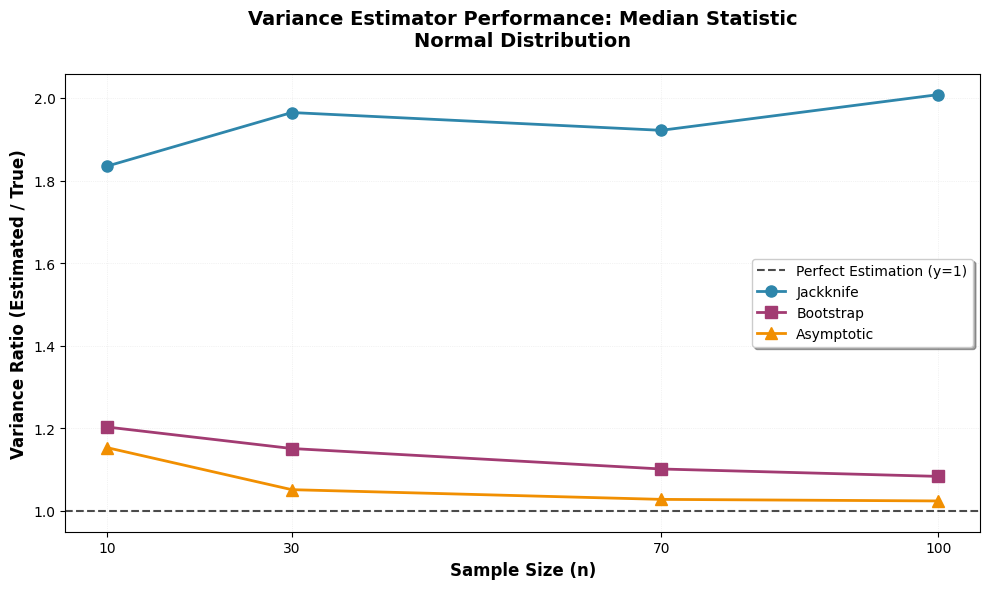


Performance for Median Statistic in Chi-Square Distribution:


100%|██████████| 5000/5000 [01:34<00:00, 52.91it/s]


,jack_performance_avg,jack_performance_sd,boot_performance_avg,boot_performance_sd,asymp_performance
10,1.931178,4.633434,1.627741,1.926097,0.875096
30,2.125878,5.038438,1.279210,1.087687,0.952127
70,2.140299,5.396527,1.158162,0.759000,0.974610
100,2.004389,4.566670,1.117911,0.648330,0.992302


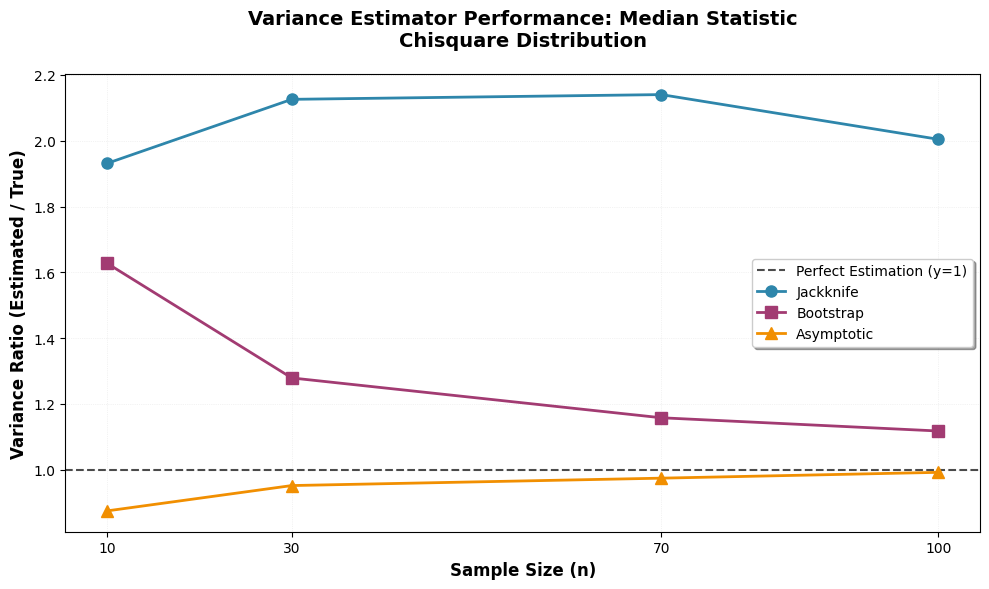

In [3]:
# Run analysis and create plots
print("\nPerformance for Median Statistic in Normal Distribution:")
results_median_normal = get_performance("median", "normal")
display(results_median_normal)
plot_performance(results_median_normal, "median", "normal")

print("\nPerformance for Median Statistic in Chi-Square Distribution:")
results_median_chisq = get_performance("median", "chisquare")
display(results_median_chisq)
plot_performance(results_median_chisq, "median", "chisquare")

Performance for Mean Statistic in Normal Distribution:


100%|██████████| 5000/5000 [00:52<00:00, 96.06it/s] 


,jack_performance_avg,jack_performance_sd,boot_performance_avg,boot_performance_sd,asymp_performance
10,0.985391,0.460973,0.880199,0.433311,0.988982
30,0.987780,0.261945,0.944004,0.282645,0.990923
70,0.991467,0.166022,0.964968,0.214488,0.989488
100,0.991944,0.137277,0.970407,0.192881,0.992603


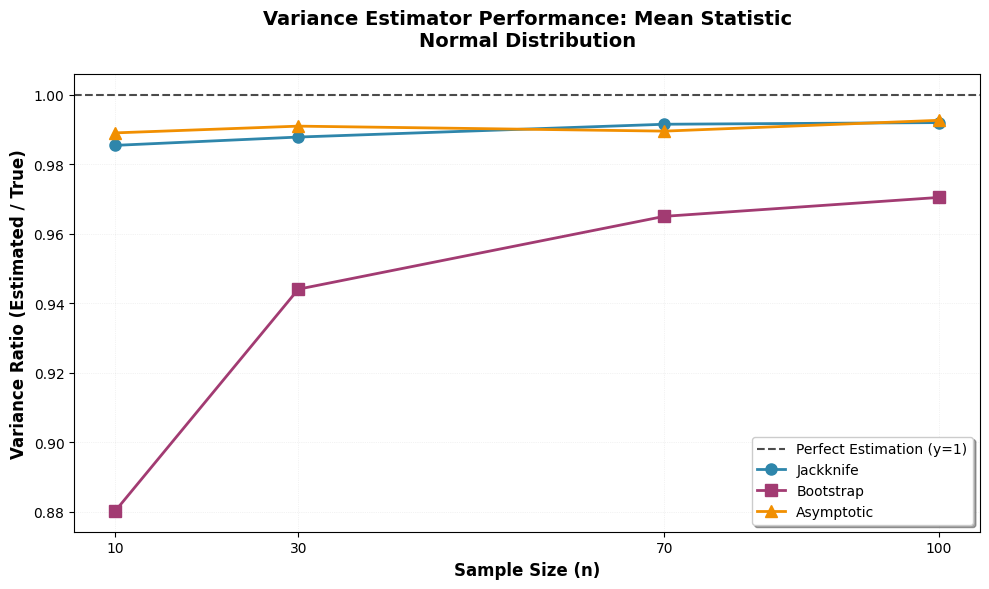


Performance for Mean Statistic in Chi-Square Distribution:


100%|██████████| 5000/5000 [00:54<00:00, 91.47it/s] 


,jack_performance_avg,jack_performance_sd,boot_performance_avg,boot_performance_sd,asymp_performance
10,0.966982,1.092541,0.856780,0.974796,0.976717
30,1.014962,0.704543,0.969482,0.692145,0.993862
70,0.983327,0.436919,0.961159,0.457249,0.984651
100,0.988313,0.362953,0.972105,0.392338,0.998592


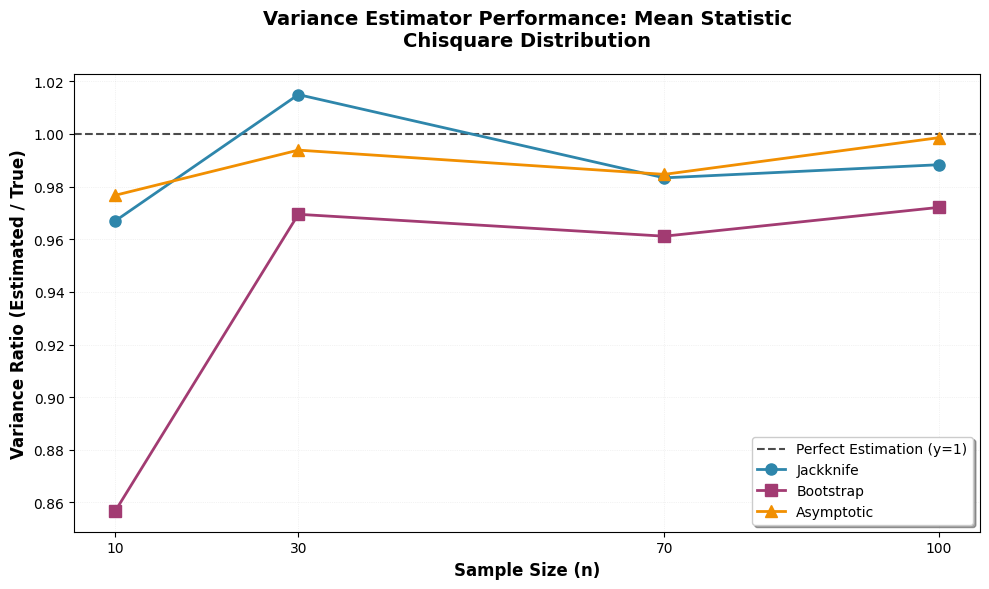

In [4]:
print("Performance for Mean Statistic in Normal Distribution:")
results_mean_normal = get_performance("mean", "normal")
display(results_mean_normal)
plot_performance(results_mean_normal, "mean", "normal")

print("\nPerformance for Mean Statistic in Chi-Square Distribution:")
results_mean_chisq = get_performance("mean", "chisquare")
display(results_mean_chisq)
plot_performance(results_mean_chisq, "mean", "chisquare")